# Creating a Shallow Neural Network

[**1. Initialization**](#1.-Initialization)

[**2. Model Building**](#2.-Model-Building)

[**3. Hyperparameter Tunning**](#3.-Hyperparameter-Tunning)

[**4. Predicting and Evaluation**](#4.-Predicting-and-Evaluation)


## 1. Initialization

### 1.1. Package imports

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

### 1.2. Loading Data

**m**: total number of samples  
**n_x**: number of features  
**n_y**: number of output classes  
**X**: input data  
**Y**: labels  
**newY**: labels extracted into rows of different classes as bool

In [128]:
data = pd.read_csv("winequality-red.csv")

shape_data = data.shape
m = shape_data[0]
n_x = shape_data[1]-1
n_y = 6

X = np.reshape(np.array(data.iloc[:,:n_x]),(m,n_x))
X = X.T
Y = np.reshape(np.array(data.iloc[:,n_x]),(m,1))
Y = Y.T

newY = np.empty((0,m), int)
for i in range(3,9):
    newY = np.append(newY,(Y==i).astype(int),axis=0)

shape_X = np.shape(X)
shape_Y = np.shape(Y)
shape_newY = np.shape(newY)


print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('The shape of newY is: ' + str(shape_newY))
print ('Total number of examples: %d' % (m))

The shape of X is: (11, 1599)
The shape of Y is: (1, 1599)
The shape of newY is: (6, 1599)
Total number of examples: 1599


### 1.3. Deviding Data into Train, Cross Validation and Test sets

**train**: training set  
**cv**: cross validation set  
**test**: test set  

In [206]:
m_train = int(m*0.6)
m_cv = int(m*0.2)
m_test = m - m_train - m_cv

X_train , X_cv , X_test = np.split(X , [m_train,m_train+m_cv] , axis=1)
Y_train , Y_cv , Y_test = np.split(newY , [m_train,m_train+m_cv] , axis=1)

## 2. Model Building

### 2.1. Defining neural network structure

**n_x**: the size of the input layer (this is number of features)  
**n_h**: the size of the hidden layer (this is initially set to 8, but will be tunned in next section)  
**n_y**: the size of the output layer (based on the data, Y has 6 unique values from 3 to 8 inclusive)

In [207]:
n_x
n_h = 8
n_y

print("n_x = %d \nn_h = %d \nn_y = %d" %(n_x,n_h,n_y))

n_x = 11 
n_h = 8 
n_y = 6


### 2.2. Initializing the model's parameters

**parameters**: python dictionary containing:  
*W1*: weight matrix of shape (n_h, n_x)  
*b1*: bias vector of shape (n_h, 1)  
*W2*: weight matrix of shape (n_y, n_h)  
*b2*: bias vector of shape (n_y, 1)

In [208]:
def initialize_parameters(n_x, n_h, n_y):
    
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 2.3. Defining Sigmoid function

In [209]:
def sigmoid(z):
    
    s = 1/(1+np.exp(-z))
        
    return s

### 2.4. Implementing forward propagation

**Z1**: W1\*X+b1  
**A1**: The tanh output of the first layer activation  
**Z2**: W2\*A1+b2  
**A2**: The sigmoid output of the second layer activation  
**tmp**: a dictionary containing "Z1", "A1", "Z2" and "A2"

In [210]:
def forward_propagation(X, parameters):
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
   
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1)+b2
    A2 = sigmoid(Z2)
        
    assert(A2.shape == (n_y, X.shape[1]))
    
    tmp = {"Z1": Z1,
           "A1": A1,
           "Z2": Z2,
           "A2": A2}
    
    return A2, tmp

### 2.5. Computing Cost

**cost**: cross-entropy cost

In [211]:
def compute_cost(A2, Y):
    
    m = Y.shape[1]

    cost = (-1/m)*np.sum(Y*np.log(A2)+(1-Y)*np.log(1-A2))
    cost = float(np.squeeze(cost))  # making sure cost is the dimension we expect!
                                    
    assert(isinstance(cost, float))
    
    return cost

### 2.6. Implementing backward propagation

**grads**: python dictionary containing gradients with respect to different parameters

In [136]:
def backward_propagation(parameters, tmp, X, Y):

    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
   
    A1 = tmp["A1"]
    A2 = tmp["A2"]

    dZ2 = A2-Y
    dW2 = (1/m)*np.dot(dZ2,A1.T)
    db2 = (1/m)*np.sum(dZ2,axis=1,keepdims=True)
    dZ1 = np.dot(W2.T,dZ2)*(1-np.power(A1,2))
    dW1 = (1/m)*np.dot(dZ1,X.T)
    db1 = (1/m)*np.sum(dZ1,axis=1,keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

### 2.7. Parameters update

In [212]:
def update_parameters(parameters, grads, learning_rate):

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 2.8. Integrating the Model

In [213]:
def nn_model(X, Y, n_h, learning_rate, num_iterations = 10000, print_cost=False):

    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):
        A2, tmp = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, tmp, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

## 3. Hyperparameter Tunning

### 3.1. Implementing prediction function

In [142]:
def predict(parameters, X):
    
    A2, tmp = forward_propagation(X, parameters)
    
    predictions = (A2==np.max(A2,axis=0)).astype(int)
    
    return predictions

### 3.2. Implementing evaluation function

In [196]:
def pred_evaluation(predictions,Y):
    m = np.shape(Y)[1]
    correct = np.sum(np.min((predictions==Y).astype(int),axis=0))
    accuracy = correct/m*100
    
    return accuracy    

In [203]:
a=np.array([[1,2,3,4],[5,6,7,8]])
b=np.array([[1,2,3,4],[5,6,7,8]])
correct = np.sum(np.min((a==b).astype(int),axis=0))
print(a)
print(b)
print(correct)
print(pred_evaluation(a,b))

[[1 2 3 4]
 [5 6 7 8]]
[[1 2 3 4]
 [5 6 7 8]]
4
100.0


In [220]:
test_n_h = (2,3,4,5,6,7,8,9,10,15,20,30,50,70,100)
accuracy_log = []
for i in test_n_h:
    parameters = nn_model(X_train, Y_train, n_h = i, learning_rate=0.5, num_iterations = 1000)
    predictions = predict(parameters, X_cv)
    accuracy = pred_evaluation(predictions,Y_cv)
    accuracy_log.append(accuracy)
    
print(accuracy_log)
print("The model accuracy is %d" %accuracy)

[27.586206896551722, 27.586206896551722, 47.02194357366771, 27.586206896551722, 47.02194357366771, 40.43887147335423, 41.692789968652036, 47.96238244514107, 41.06583072100313, 43.8871473354232, 19.74921630094044, 19.74921630094044, 3.4482758620689653, 47.96238244514107, 27.586206896551722]
The model accuracy is 27


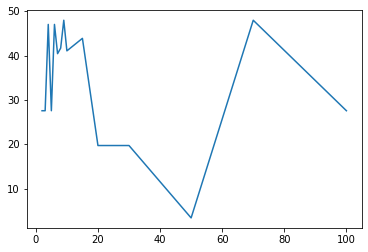

In [221]:
plt.plot(test_n_h, accuracy_log)

## 4. Predicting and Evaluation